# Inference Notebook VAE
The inference notebook is used for any experiments doe outside of the Training, All training are done using the python scripts.

The inference code includes all the Pyro implementations for the Unsupervised VAE. The models are called and the inference are made. This Ipython notebook can be used to generate the sample of sources as well as post analysis of the generated images.

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam,Adagrad
import pyro.poutine as poutine
from torchvision.utils import save_image

import matplotlib.pylab as plt

from PIL import Image # Module for image rotation (making use of PIL)

from utils.models import HMT

In [3]:
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp

In [4]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [5]:
#from utils.MiraBest import MiraBest
from utils.MiraBest_full import MiraBest_full
from utils.FRDEEP import FRDEEPF
from utils.data_downloader import dataloader_first_FRDEEP
from utils.data_downloader import dataloader_first
from utils.classification_function import classfication_procedure

In [6]:
#import network_configurations.neural_net_conf_0_2 as network #change this here to change configuration

import network_configurations.neural_net_conf_0_2_dropout as network


In [7]:
def inception_score():
    model = HMT().cuda()
    model.load_state_dict(torch.load('model.mod'))
    
    return model.eval()

In [8]:
inception_classifier = inception_score()

In [9]:
def calculate_inception_score(p_yx, eps=1E-16):
	# calculate p(y)
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each image
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over images
	avg_kl_d = mean(sum_kl_d)
	# undo the logs
	is_score = exp(avg_kl_d)
	return is_score

In [10]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # @David We have changed the latent space to 2-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim,h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim, use_cuda=True): # z_dim has been changed to 2
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        #For the first images add addition hidden layers
        self.encoder = network.Encoder(x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim) #To check the layering structure
        self.decoder = network.Decoder(x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim) #To check the layering structure

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # Do not touch this part for the time being this will be modified when doing the Semi-Supervised VAE     
    # define the model p(x|z)p(z)
    #-------------------------------------------------------------------------------------------------------------------
    #-----------------------------------------------Model Chunck--------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------------
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 10000))
    #------------------------------------------------------------------------------------------------------------------
    
    #------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------Guide Chunk-----------------------------------------------------
    #------------------------------------------------------------------------------------------------------------------
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    #------------------------------------------------------------------------------------------------------------------


    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [11]:
# Note that the mini batch logic is handled by the data loader, we should duplicate the same logic of the data loader with the FIRST Database. The core of the training loop is svi.step(x). This is the data entry point. It should be noted that we have to change the looping structure to that of the mini batch structure that is used for the FIRST database.

# To do evaluate part afterwards

def evaluate(svi, test_loader, use_cuda=True):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x) #Data entry point <---------------------------------Data Entry Point
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [12]:
def single_image_sampler(z0=0.0,z1=0.0):
    z = torch.rand(1,2).cuda()
    z[0,0]=z0
    z[0,1]=z1
    single_sample_image = vae.decoder(z)
    image_array_single =single_sample_image.reshape(100,100).cpu().detach().numpy()
    temp_array=image_array_single
    plt.figure(figsize = (10,10))
    plt.imshow(image_array_single)
    plt.colorbar()
    plt.show()
    return image_array_single

# Recalls FRDEEP images

In [13]:
x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')

In [14]:
x.shape

(500, 1, 150, 150)

In [15]:
def inference_function(latent_dimension,weights_dir,epoch):
    data = np.zeros((5,4000)).T

    columns = ['Epoch','Train_Loss', 'Test_Loss', 'Sigma_clipped','Inception_score']
    df = pd.DataFrame(data, columns=columns)
    #ForNetwork without dropout use 0.0013

    # Run options
    LEARNING_RATE = 0.00125
    USE_CUDA = True

    # Run only for a single iteration for testing
    NUM_EPOCHS = 1 if smoke_test else 6000
    TEST_FREQUENCY = 5

    # Core Training section
    #-----------------------------------------------Main VAE Section--------------------------------------------


    # clear param store


    # setup the VAE
    vae = VAE(x_dim=10000,h_dim1=4096,h_dim2=2048,h_dim3=1024,h_dim4=512,h_dim5=256,z_dim=latent_dimension,use_cuda=USE_CUDA)

    # setup the optimizer
    adam_args = {"lr": LEARNING_RATE}
    # optimizer = Adam(adam_args)   # The Adam optimizer is used as optimizer
    optimizer = Adagrad(adam_args)
    # setup the inference algorithm
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
    #svi = SVI(vae.model, vae.guide, optimizer, loss=simple_elbo)
    #svi = SVI(vae.model, vae.guide, optimizer, loss=simple_elbo_kl_annealing)

    #svi.step(annealing_factor=0.2, latents_to_anneal=["my_latent"])
    
    #print("loading model from ...")
    vae.load_state_dict(torch.load('/raid/scratch/davidb/1_DEVELOPMENT/VAE_FIRST/MODELS/'+weights_dir+'/model_unsup_main_'+str(epoch)+'.mod'))
   # print("loading optimizer states from ...")
    optimizer.load('/raid/scratch/davidb/1_DEVELOPMENT/VAE_FIRST/MODELS/'+weights_dir+'/model_unsup_main_'+str(epoch)+'_opt.opt')
   # print("done loading model and optimizer states.")
    
    return vae

In [16]:
def inception_scoring():
    z_fr = torch.randn(100, 2)

    for i in range (0,100):
        z_fr[i,0] = np.random.uniform(-4,4)
        z_fr[i,1] = np.random.uniform(-4,4)
    
    sample1 = vae.decoder(z_fr.cuda()).cpu().detach().numpy().reshape(100,1,100,100)
    
    fullsize_image = np.zeros((100,1,150,150))

    for i in range (0,100):
        fullsize_image[i,0,25:125,25:125]=sample1[i,0,:,:]
    
    array_generated= torch.from_numpy(fullsize_image).float().to("cpu")

    valid_pred = inception_classifier(array_generated.cuda())
    m = nn.Softmax(dim=1)
    values=m(valid_pred).cpu().detach().numpy()
    score = calculate_inception_score(values)

    return score

In [17]:
z = np.zeros((2,))

## Experiment 1: 
Original and reconstructed images at different latent dimensions. 1st row shows the originalimages from the train set of FRDEEP. Row 2 through 6 show the reconstructed images for $d=2,4,8,16$ and $32$


Please refer to Figure 4.9 Section 4.3.1

printed_count:1
2
main_main_06july2020
3200
printed_count:2
4
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
7900
printed_count:3
8
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
7900
printed_count:4
16
USUP-MODELS-d16-0-0009400000000000012-2020-07-30
7900
printed_count:5
32
USUP-MODELS-d32-0-0009400000000000012-2020-08-03
7900
printed_count:6
64
USUP-MODELS-d64-0-0009400000000000012-2020-09-14
7900
printed_count:1
2
main_main_06july2020
3200
printed_count:2
4
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
7900
printed_count:3
8
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
7900
printed_count:4
16
USUP-MODELS-d16-0-0009400000000000012-2020-07-30
7900
printed_count:5
32
USUP-MODELS-d32-0-0009400000000000012-2020-08-03
7900
printed_count:6
64
USUP-MODELS-d64-0-0009400000000000012-2020-09-14
7900
printed_count:1
2
main_main_06july2020
3200
printed_count:2
4
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
7900
printed_count:3
8
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
7900
prin

<Figure size 432x288 with 0 Axes>

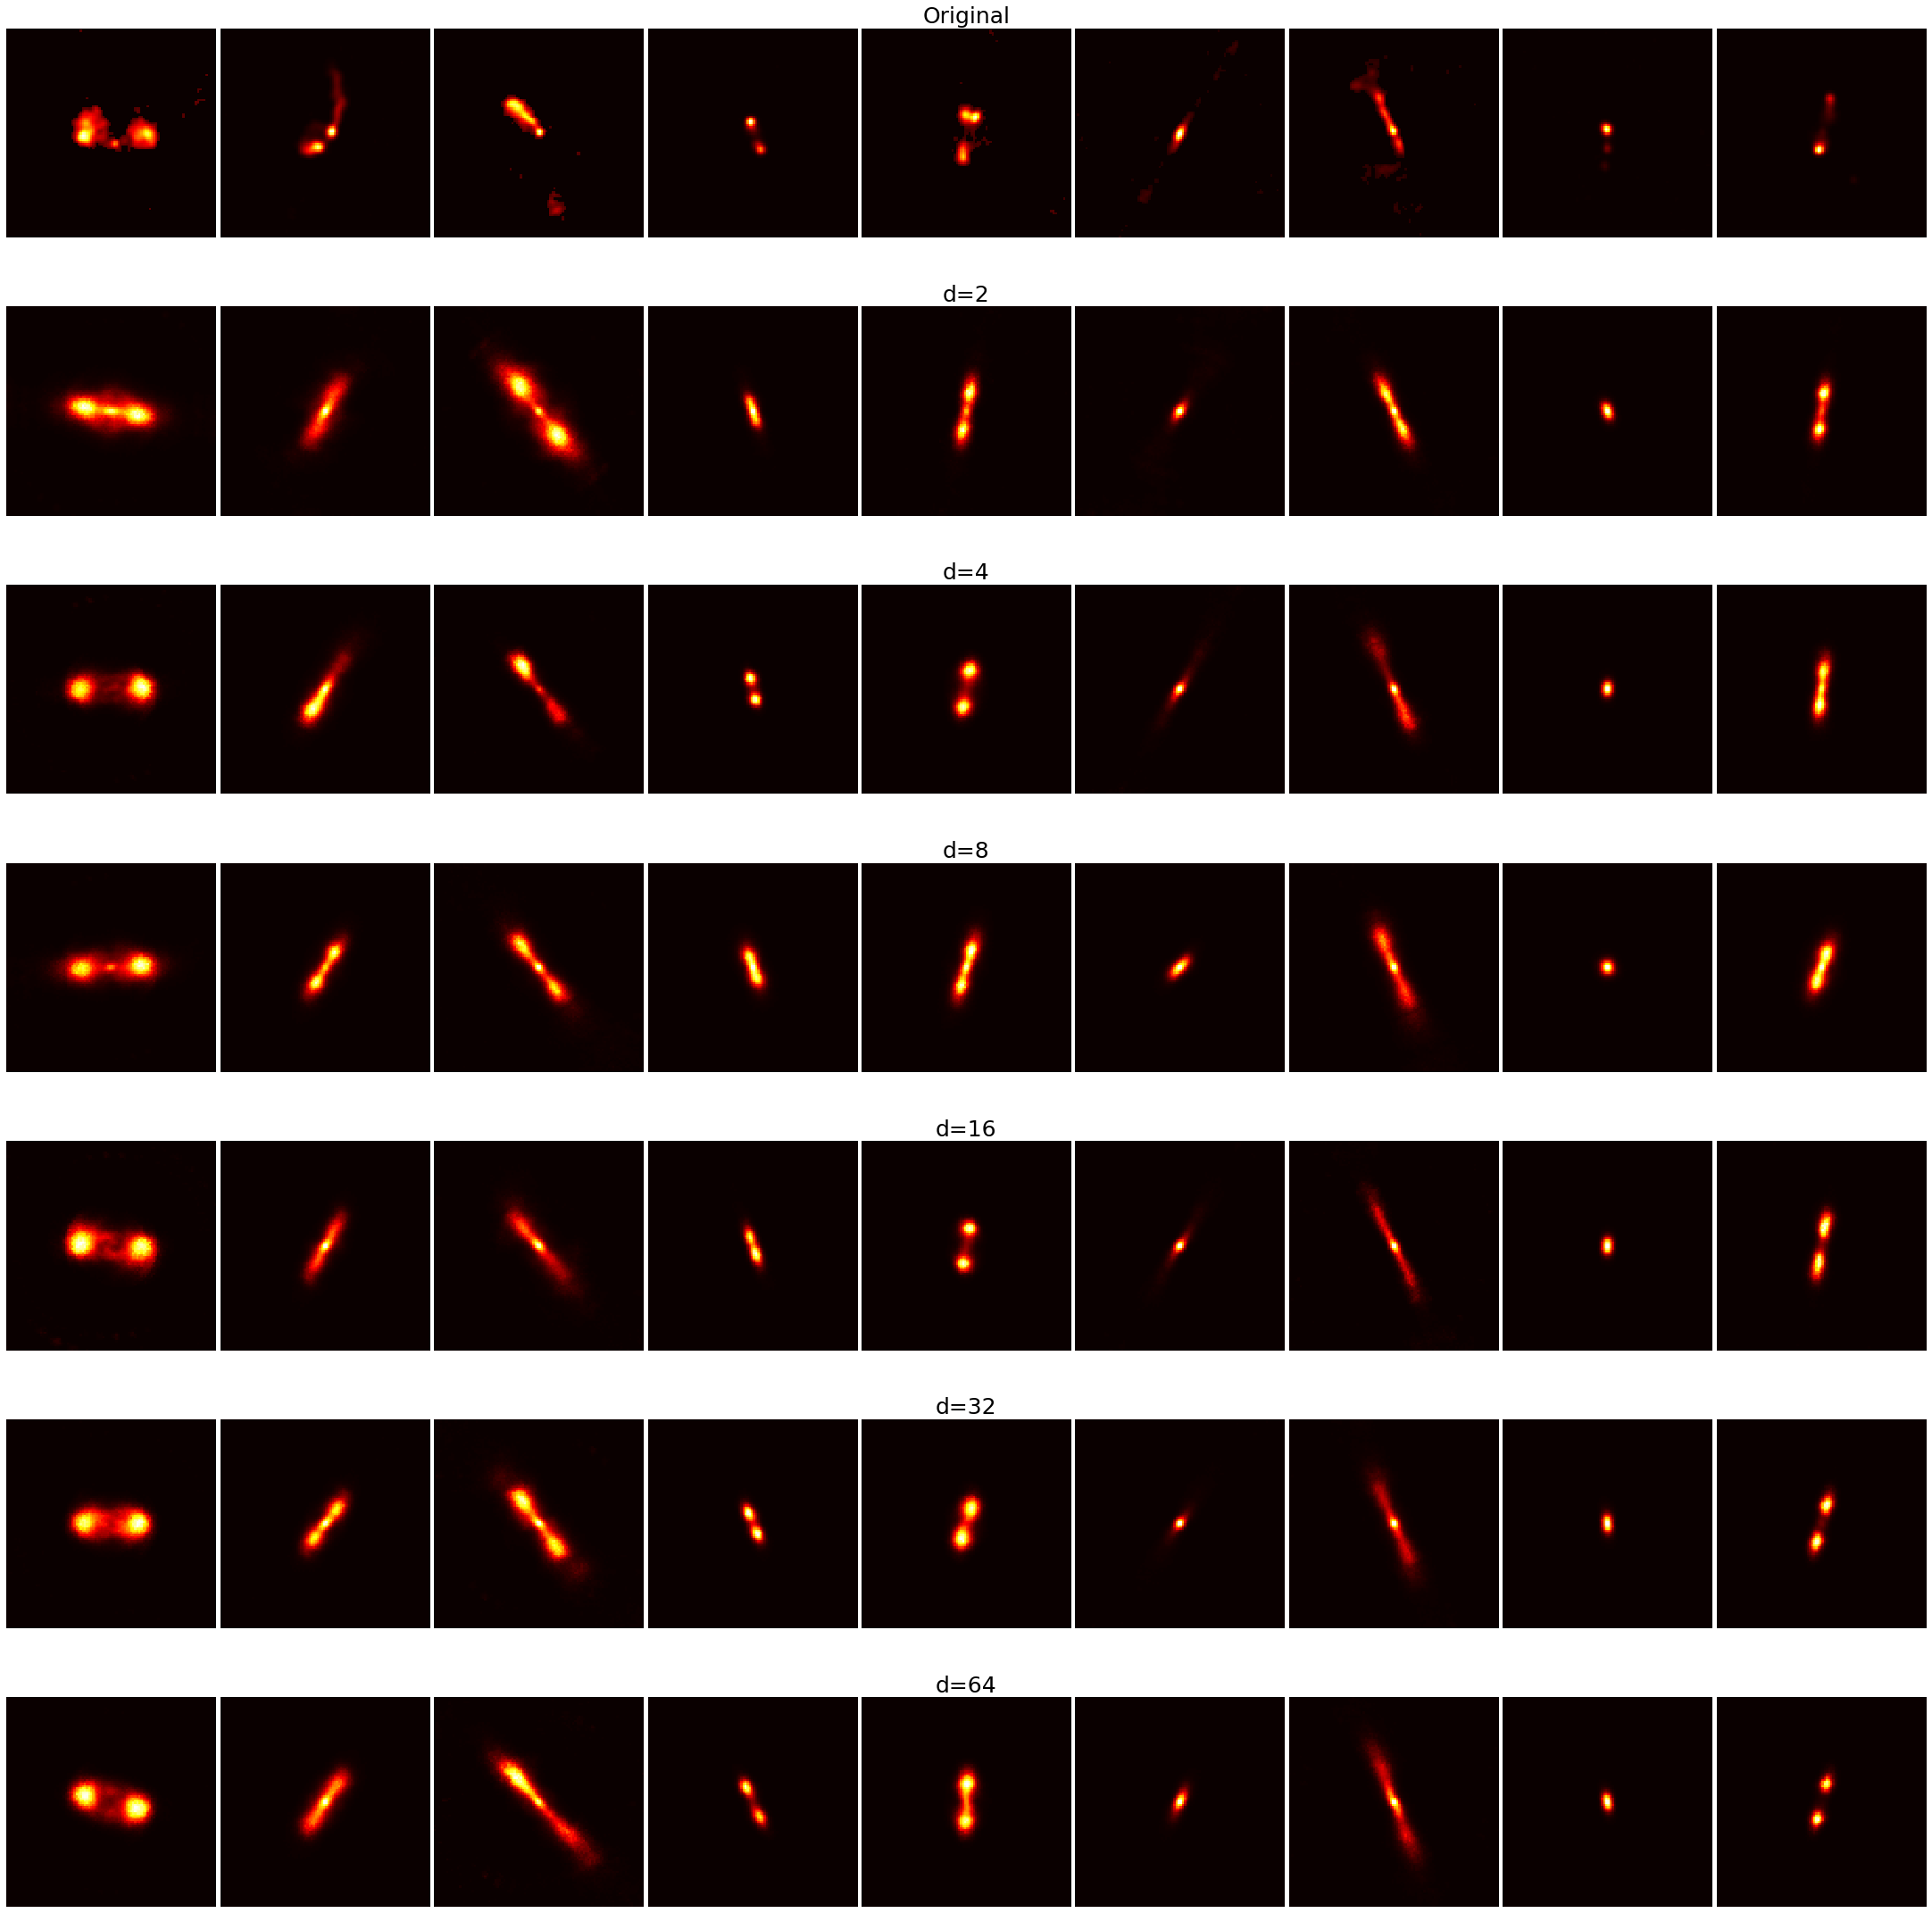

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)
plt.figure(figsize=(30,35))
plots = []
images = [400,403,302,202,6,60,62,67,86]
bluring_kernel = [1,5,9,13,17]
epoch = [100,200,400,800,1600,3200,5000]


directory_list=[0,'main_main_06july2020','USUP-MODELS-d4-0-0009600000000000012-2020-07-27','USUP-MODELS-d8-0-0010400000000000014-2020-07-28','USUP-MODELS-d16-0-0009400000000000012-2020-07-30','USUP-MODELS-d32-0-0009400000000000012-2020-08-03','USUP-MODELS-d64-0-0009400000000000012-2020-09-14']
epoch_list=[0,3200,7900,7900,7900,7900,7900]
latent_dimensions_loop = [0,2,4,8,16,32,64]


for i in range(9):
    count = 0
    image_torec = x[images[i]][0][25:125,25:125]
    for weight_out in directory_list:
            
            if weight_out == 0:
                ax = plt.subplot2grid((8,9), (count,i))
                ax.imshow(image_torec,cmap='hot')
                ax.set_axis_off()
                count = count+1
            else:
                print('printed_count:'+str(count))
                print(latent_dimensions_loop[count])
                print(weight_out)
                print(epoch_list[count])
                vae_2 = inference_function(latent_dimensions_loop[count],weight_out,epoch_list[count])
                to_rec = image_torec.reshape(10000)
                to_rec_torch=torch.from_numpy(to_rec).float().to("cuda:0")
                [z_mean,z_sig]=vae_2.encoder(to_rec_torch)
                x_torch=vae_2.decoder(z_mean)
                img_rec=x_torch.reshape(100,100).cpu().detach().numpy()
                ax = plt.subplot2grid((8,9), (count,i))
                ax.imshow(img_rec,cmap='hot')
                ax.set_axis_off()
                count = count + 1
            
            if i == 4:
                if weight_out == 0 :
                    ax.set_title('Original',fontsize= 25)
                else:
                    ax.set_title('d='+str(latent_dimensions_loop[count-1]),fontsize= 25)

plt.tight_layout(pad = 0.5)
plt.show()

printed_count:1
64
1
printed_count:2
64
2
printed_count:3
64
3
printed_count:4
64
4
printed_count:5
64
5
printed_count:6
64
6
printed_count:1
64
1
printed_count:2
64
2
printed_count:3
64
3
printed_count:4
64
4
printed_count:5
64
5
printed_count:6
64
6
printed_count:1
64
1
printed_count:2
64
2
printed_count:3
64
3
printed_count:4
64
4
printed_count:5
64
5
printed_count:6
64
6


<Figure size 432x288 with 0 Axes>

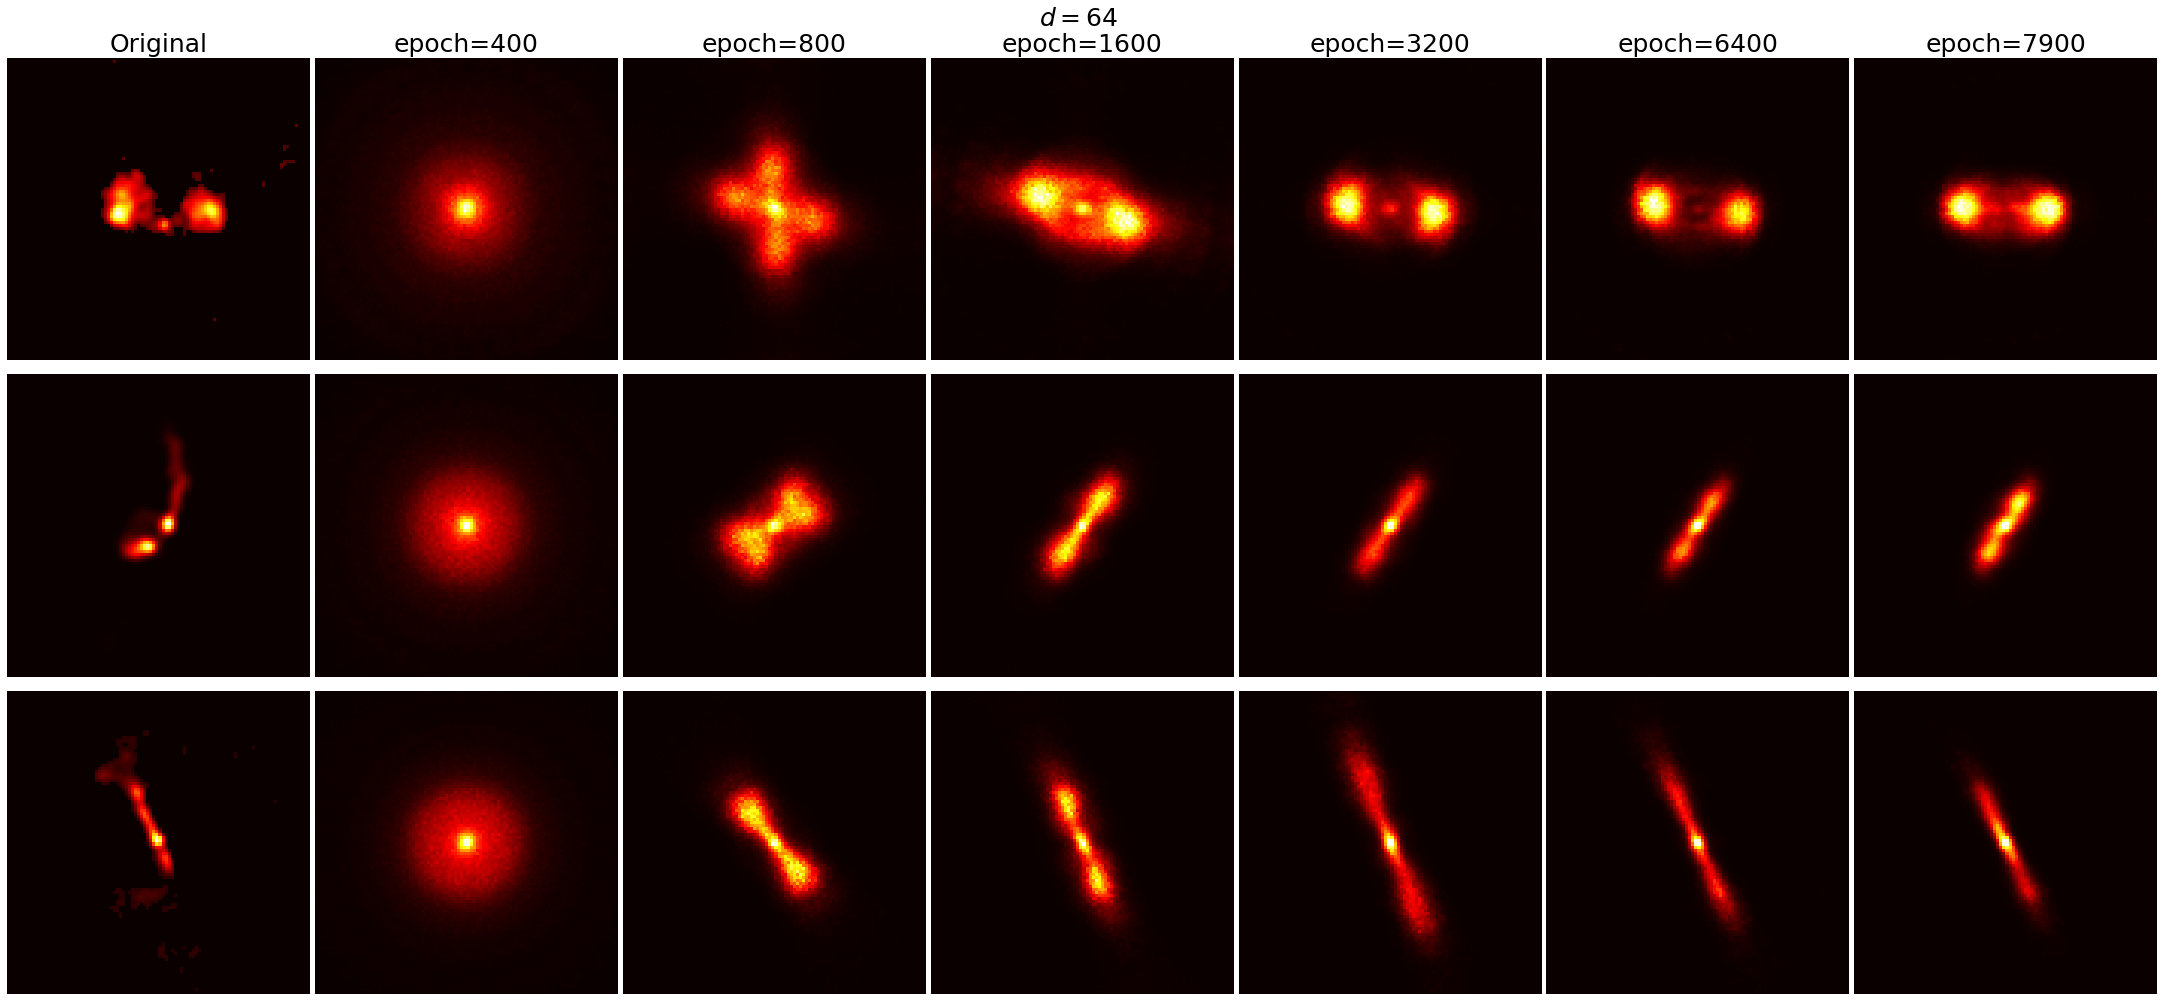

In [20]:
import matplotlib.pyplot as plt
import numpy as np




plt.figure(0)
plt.figure(figsize=(30,40))
plt.title('test')
plots = []
images = [400,403,62]
bluring_kernel = [1,5,9,13,17]
epoch = [100,400,800,1600,3200,6400,7900]
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


epoch_list=[0,3200,7900,7900,7900,7900]
latent_dimensions_loop = [0,2,4,8,16,32]
latent_d = 64

for i in range(3):
    count = 0
    image_torec = x[images[i]][0][25:125,25:125]
    for j in range (0,7):
            
            if j == 0:
                ax = plt.subplot2grid((9,7), (i,count))
                ax.imshow(image_torec,cmap='hot')
                ax.set_axis_off()
                count = count+1
            else:
                print('printed_count:'+str(count))
                print(latent_d)
                print(j)
                vae_2 = inference_function(latent_d,'USUP-MODELS-d64-0-0009400000000000012-2020-09-14',epoch[j])
                to_rec = image_torec.reshape(10000)
                to_rec_torch=torch.from_numpy(to_rec).float().to("cuda:0")
                [z_mean,z_sig]=vae_2.encoder(to_rec_torch)
                x_torch=vae_2.decoder(z_mean)
                img_rec=x_torch.reshape(100,100).cpu().detach().numpy()
                ax = plt.subplot2grid((9,7), (i,count))
                ax.imshow(img_rec,cmap='hot')
                ax.set_axis_off()
                count = count + 1
            
            if i == 0:
                if j == 0 :
                    ax.set_title('Original',fontsize= 25)
                else:
                    ax.set_title('epoch='+str(epoch[j]),fontsize= 25)

plt.tight_layout(pad = 0.5)

plt.figtext(0.48,0.999,'$d = '+str(latent_d)+'$',fontsize=25)
plt.show()

printed_count:0
2
main_main_06july2020
3200


/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


printed_count:1
4
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
7900
printed_count:2
8
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
7900
printed_count:3
16
USUP-MODELS-d16-0-0009400000000000012-2020-07-30
7900
printed_count:4
32
USUP-MODELS-d32-0-0009400000000000012-2020-08-03
7900
printed_count:5
64
USUP-MODELS-d64-0-0009400000000000012-2020-09-14
7900
printed_count:0
2
main_main_06july2020
3200
printed_count:1
4
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
7900
printed_count:2
8
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
7900
printed_count:3
16
USUP-MODELS-d16-0-0009400000000000012-2020-07-30
7900
printed_count:4
32
USUP-MODELS-d32-0-0009400000000000012-2020-08-03
7900
printed_count:5
64
USUP-MODELS-d64-0-0009400000000000012-2020-09-14
7900
printed_count:0
2
main_main_06july2020
3200
printed_count:1
4
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
7900
printed_count:2
8
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
7900
printed_count:3
16
USUP-MODELS-d16-0-00094000000

<Figure size 432x288 with 0 Axes>

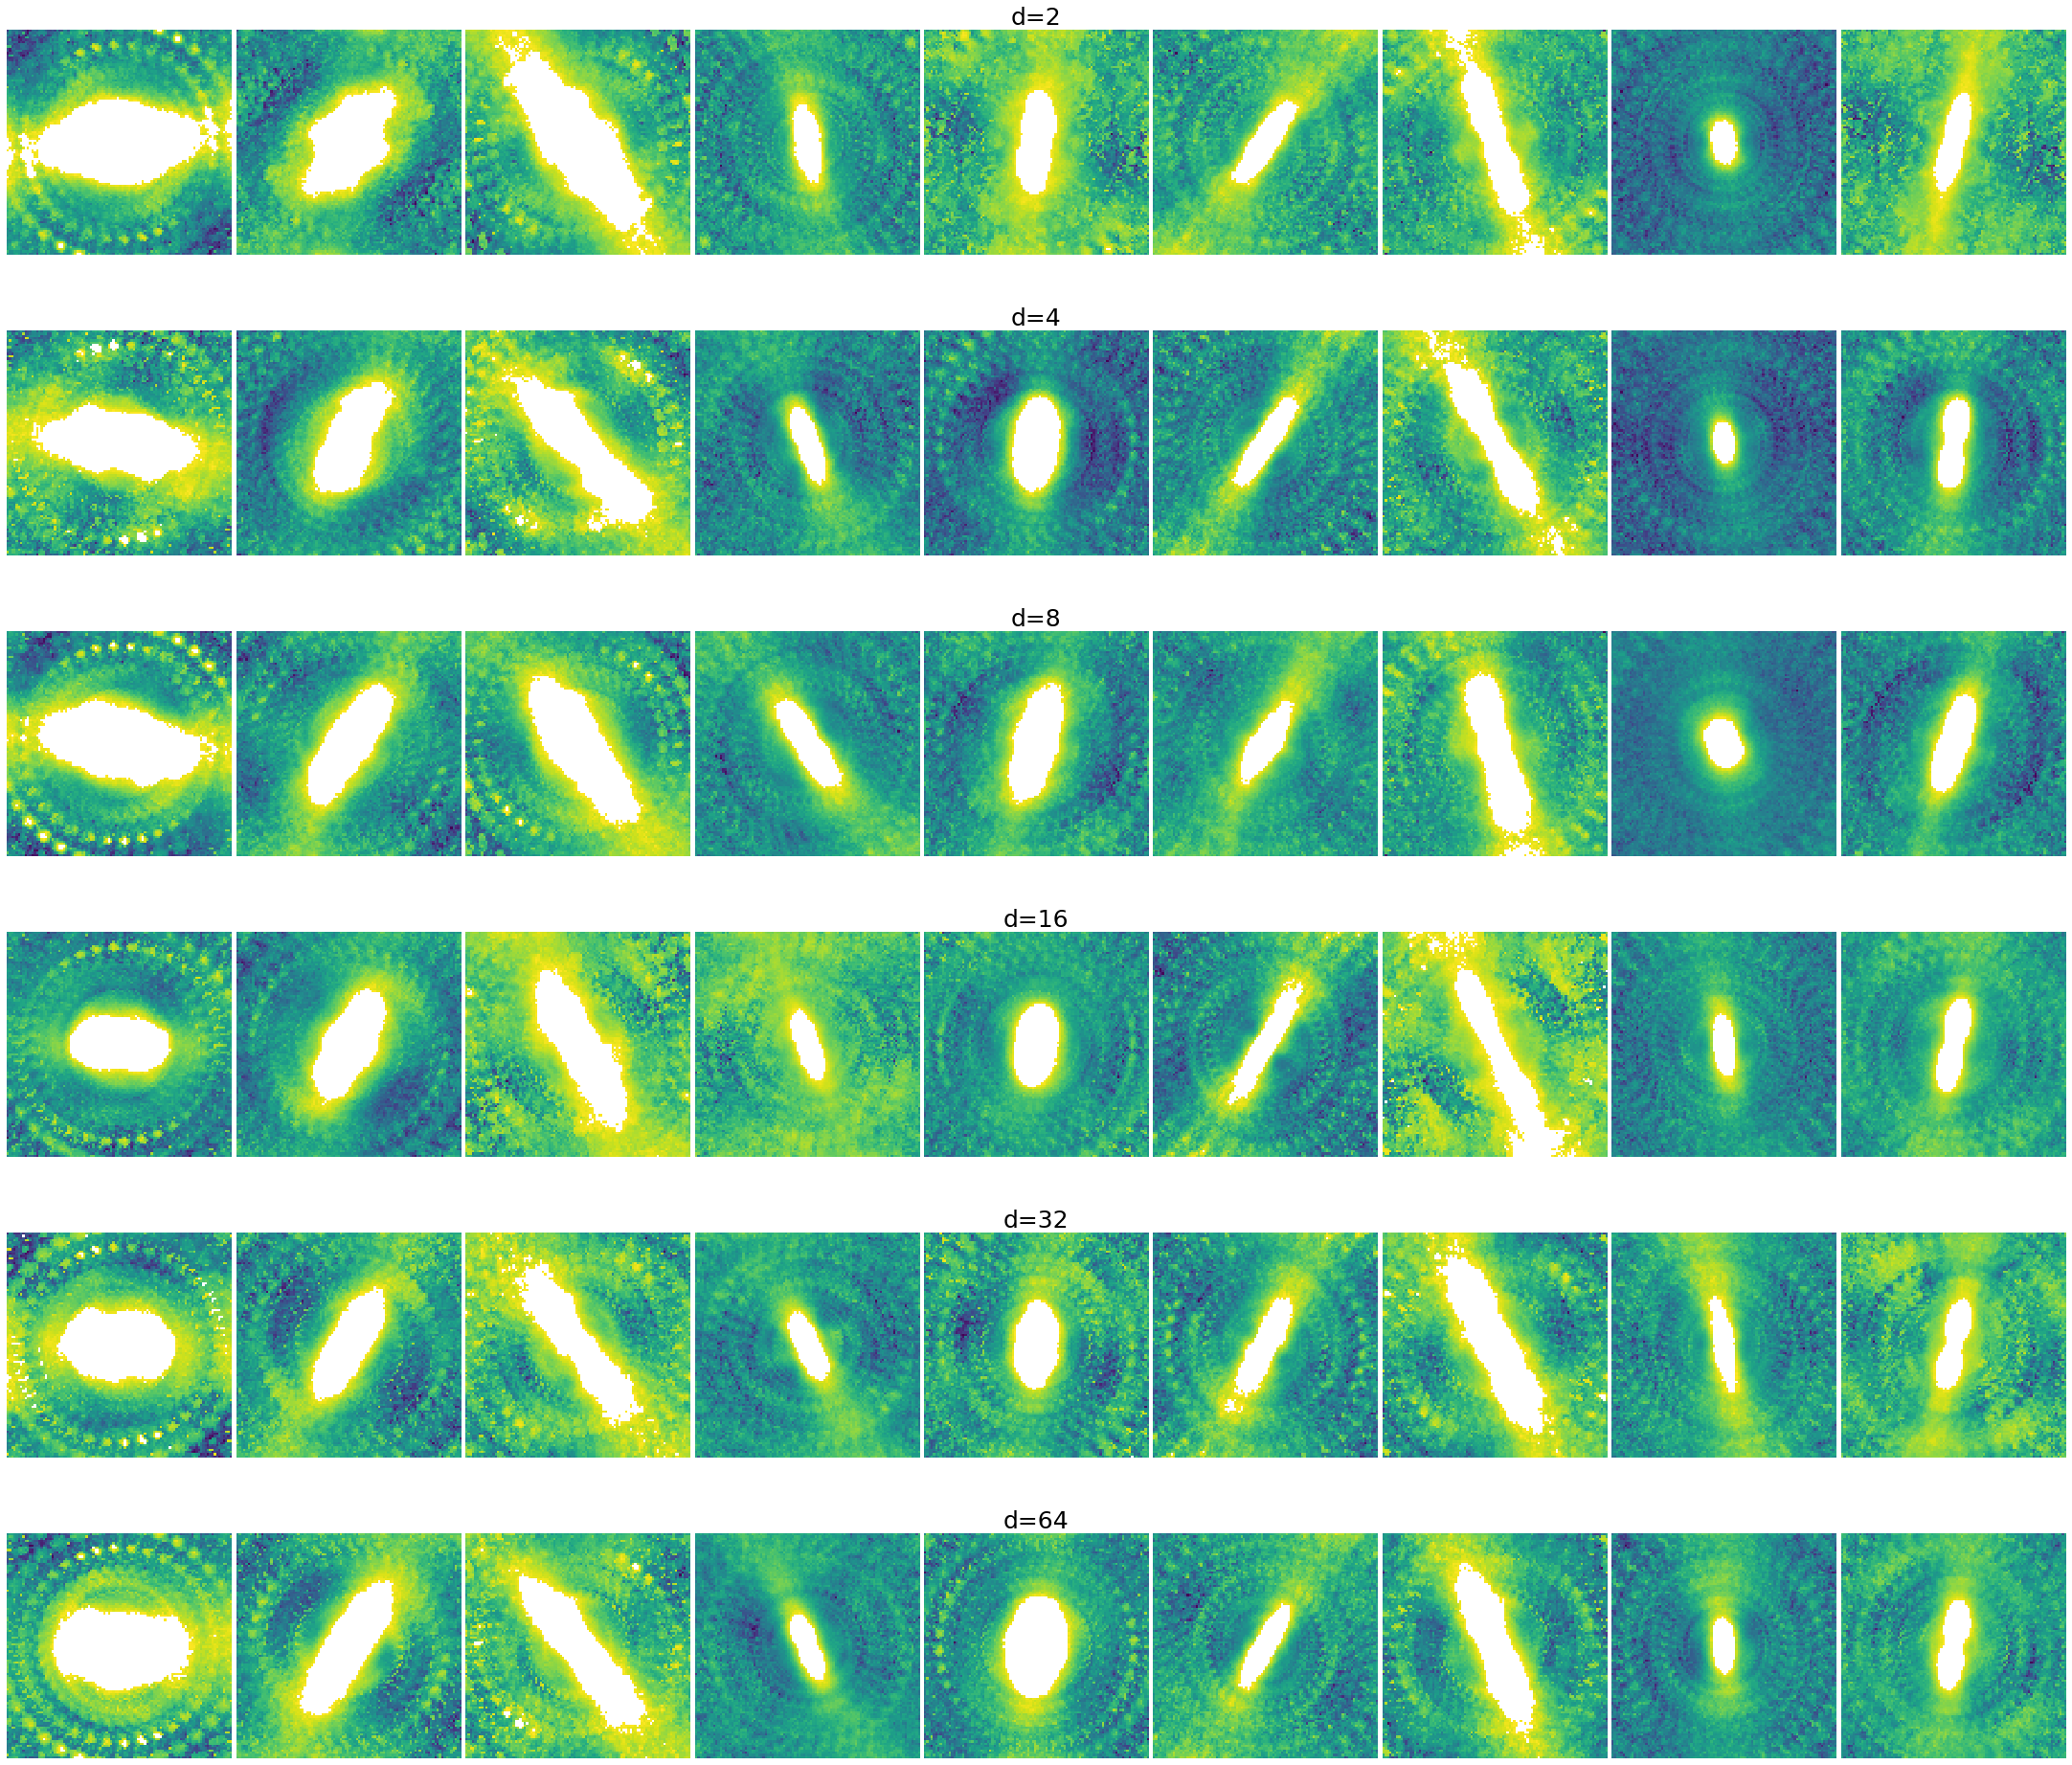

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)
plt.figure(figsize=(30,35))
plots = []
images = [400,403,302,202,6,60,62,67,86]
bluring_kernel = [1,5,9,13,17]
epoch = [100,200,400,800,1600,3200,5000]


directory_list=['main_main_06july2020','USUP-MODELS-d4-0-0009600000000000012-2020-07-27','USUP-MODELS-d8-0-0010400000000000014-2020-07-28','USUP-MODELS-d16-0-0009400000000000012-2020-07-30','USUP-MODELS-d32-0-0009400000000000012-2020-08-03','USUP-MODELS-d64-0-0009400000000000012-2020-09-14']
epoch_list=[3200,7900,7900,7900,7900,7900]
latent_dimensions_loop = [2,4,8,16,32,64]


for i in range(9):
    count = 0
    image_torec = x[images[i]][0][25:125,25:125]
    for weight_out in directory_list:
                print('printed_count:'+str(count))
                print(latent_dimensions_loop[count])
                print(weight_out)
                print(epoch_list[count])
                vae_2 = inference_function(latent_dimensions_loop[count],weight_out,epoch_list[count])
                to_rec = image_torec.reshape(10000)
                to_rec_torch=torch.from_numpy(to_rec).float().to("cuda:0")
                [z_mean,z_sig]=vae_2.encoder(to_rec_torch)
                x_torch=vae_2.decoder(z_mean)    
                img_rec=x_torch.reshape(100,100).cpu().detach().numpy()
                img_rec[img_rec > 0.0039215684]=0.0
                ax = plt.subplot2grid((8,9), (count,i))
                ax.imshow(np.log(img_rec))
                ax.set_axis_off()
                
            
                if i == 4:
                    ax.set_title('d='+str(latent_dimensions_loop[count]),fontsize= 25)
                    
                count = count + 1

plt.tight_layout(pad = 0.5)
plt.show()

In [25]:


def noise_distribution_sample(d,model_file,epoch):
    limits = np.zeros((2,d))
    for i in range (0,d):
        limits[0,i]= -4
        limits[1,i]= 4

    z_fr = torch.randn(100, d)

    for i in range (0,100):
        for j in range (0,d):
            z_fr[i,j] = np.random.uniform(limits[0,j],limits[1,j])
        
    vae_2 = inference_function(d,model_file,epoch)
    
    sample1 = vae_2.decoder(z_fr.cuda()).cpu().detach().numpy().reshape(100,1,100,100)
    
    return sample1.reshape(100*100*100)

In [26]:
import decimal
def float_range(start, stop, step):
  while start < stop:
    yield float(start)
    start += decimal.Decimal(step)







main_main_06july2020
4.4721746e-16
USUP-MODELS-d4-0-0009600000000000012-2020-07-27
3.731449e-20
USUP-MODELS-d8-0-0010400000000000014-2020-07-28
1.4898629e-14
USUP-MODELS-d16-0-0009400000000000012-2020-07-30
2.3206953e-20
USUP-MODELS-d32-0-0009400000000000012-2020-08-03
9.419633e-26
USUP-MODELS-d64-0-0009400000000000012-2020-09-14
5.984814e-25


<Figure size 432x288 with 0 Axes>

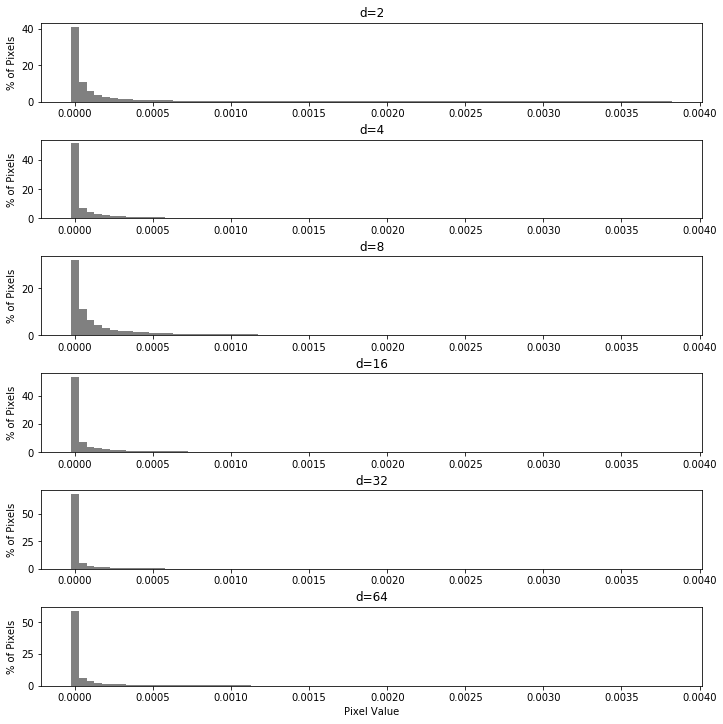

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)

plots = []
images = [400,403,302,202,6,60,62,67,86]
bluring_kernel = [1,5,9,13,17]
epoch = [100,200,400,800,1600,3200,5000]


directory_list=['main_main_06july2020','USUP-MODELS-d4-0-0009600000000000012-2020-07-27','USUP-MODELS-d8-0-0010400000000000014-2020-07-28','USUP-MODELS-d16-0-0009400000000000012-2020-07-30','USUP-MODELS-d32-0-0009400000000000012-2020-08-03','USUP-MODELS-d64-0-0009400000000000012-2020-09-14']
epoch_list=[3200,7900,7900,7900,7900,7900]
latent_dimensions_loop = [2,4,8,16,32,64]
fig, ax = plt.subplots(6,1, figsize=(10,10))

count = 0
for weight_out in directory_list:
    print(weight_out)
    sample_reshaped=noise_distribution_sample(latent_dimensions_loop[count],weight_out,epoch_list[count])
    hist, bins = np.histogram(sample_reshaped,bins = list(float_range(0, 0.0039, '0.00005')))
    print(np.min(sample_reshaped))
    ax[count].bar(bins[:-1], hist.astype(np.float32) / (100*100), width=(bins[1]-bins[0]), color='grey')
    
    ax[count].set_ylabel('% of Pixels')
    ax[count].set_title('d='+str(latent_dimensions_loop[count]))
    
    count = count +1
    
ax[5].set_xlabel('Pixel Value')
plt.tight_layout(pad = 0.5)
plt.show()

In [111]:
np.sum(counts)

999765.0

0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
0.0
250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0


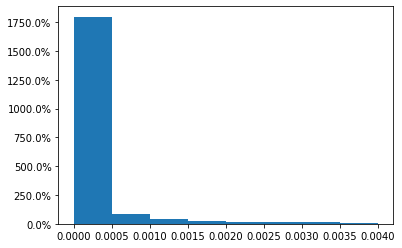

In [46]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    print(y)
    s = str(y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


# Make a normed histogram. It'll be multiplied by 100 later.
counts,x,y=plt.hist(sample_reshaped,weights=np.ones(len(sample_reshaped)) / len(sample_reshaped),density=True,bins = list(float_range(0, 0.004, '0.0005')))

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [48]:
np.sum(counts)

1999.9999999999998

In [100]:
counts.shape

(8,)

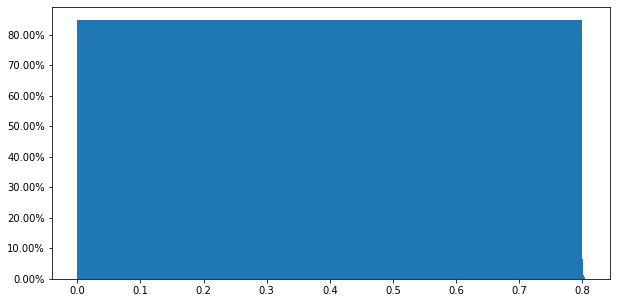

In [75]:
import matplotlib.pyplot as plt
import numpy as np

f, ax = plt.subplots(1, 1, figsize=(10,5))

heights, bins = np.histogram(sample_reshaped, bins = list(float_range(0, 0.004, '0.0005')))

percent = [i/sum(heights)*100 for i in heights]

ax.bar(bins[:-1], percent, align="edge")
vals = ax.get_yticks()
ax.set_yticklabels(['%1.2f%%' %i for i in vals])

plt.show()

In [84]:

plt.figtext(1,1,'new title')
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

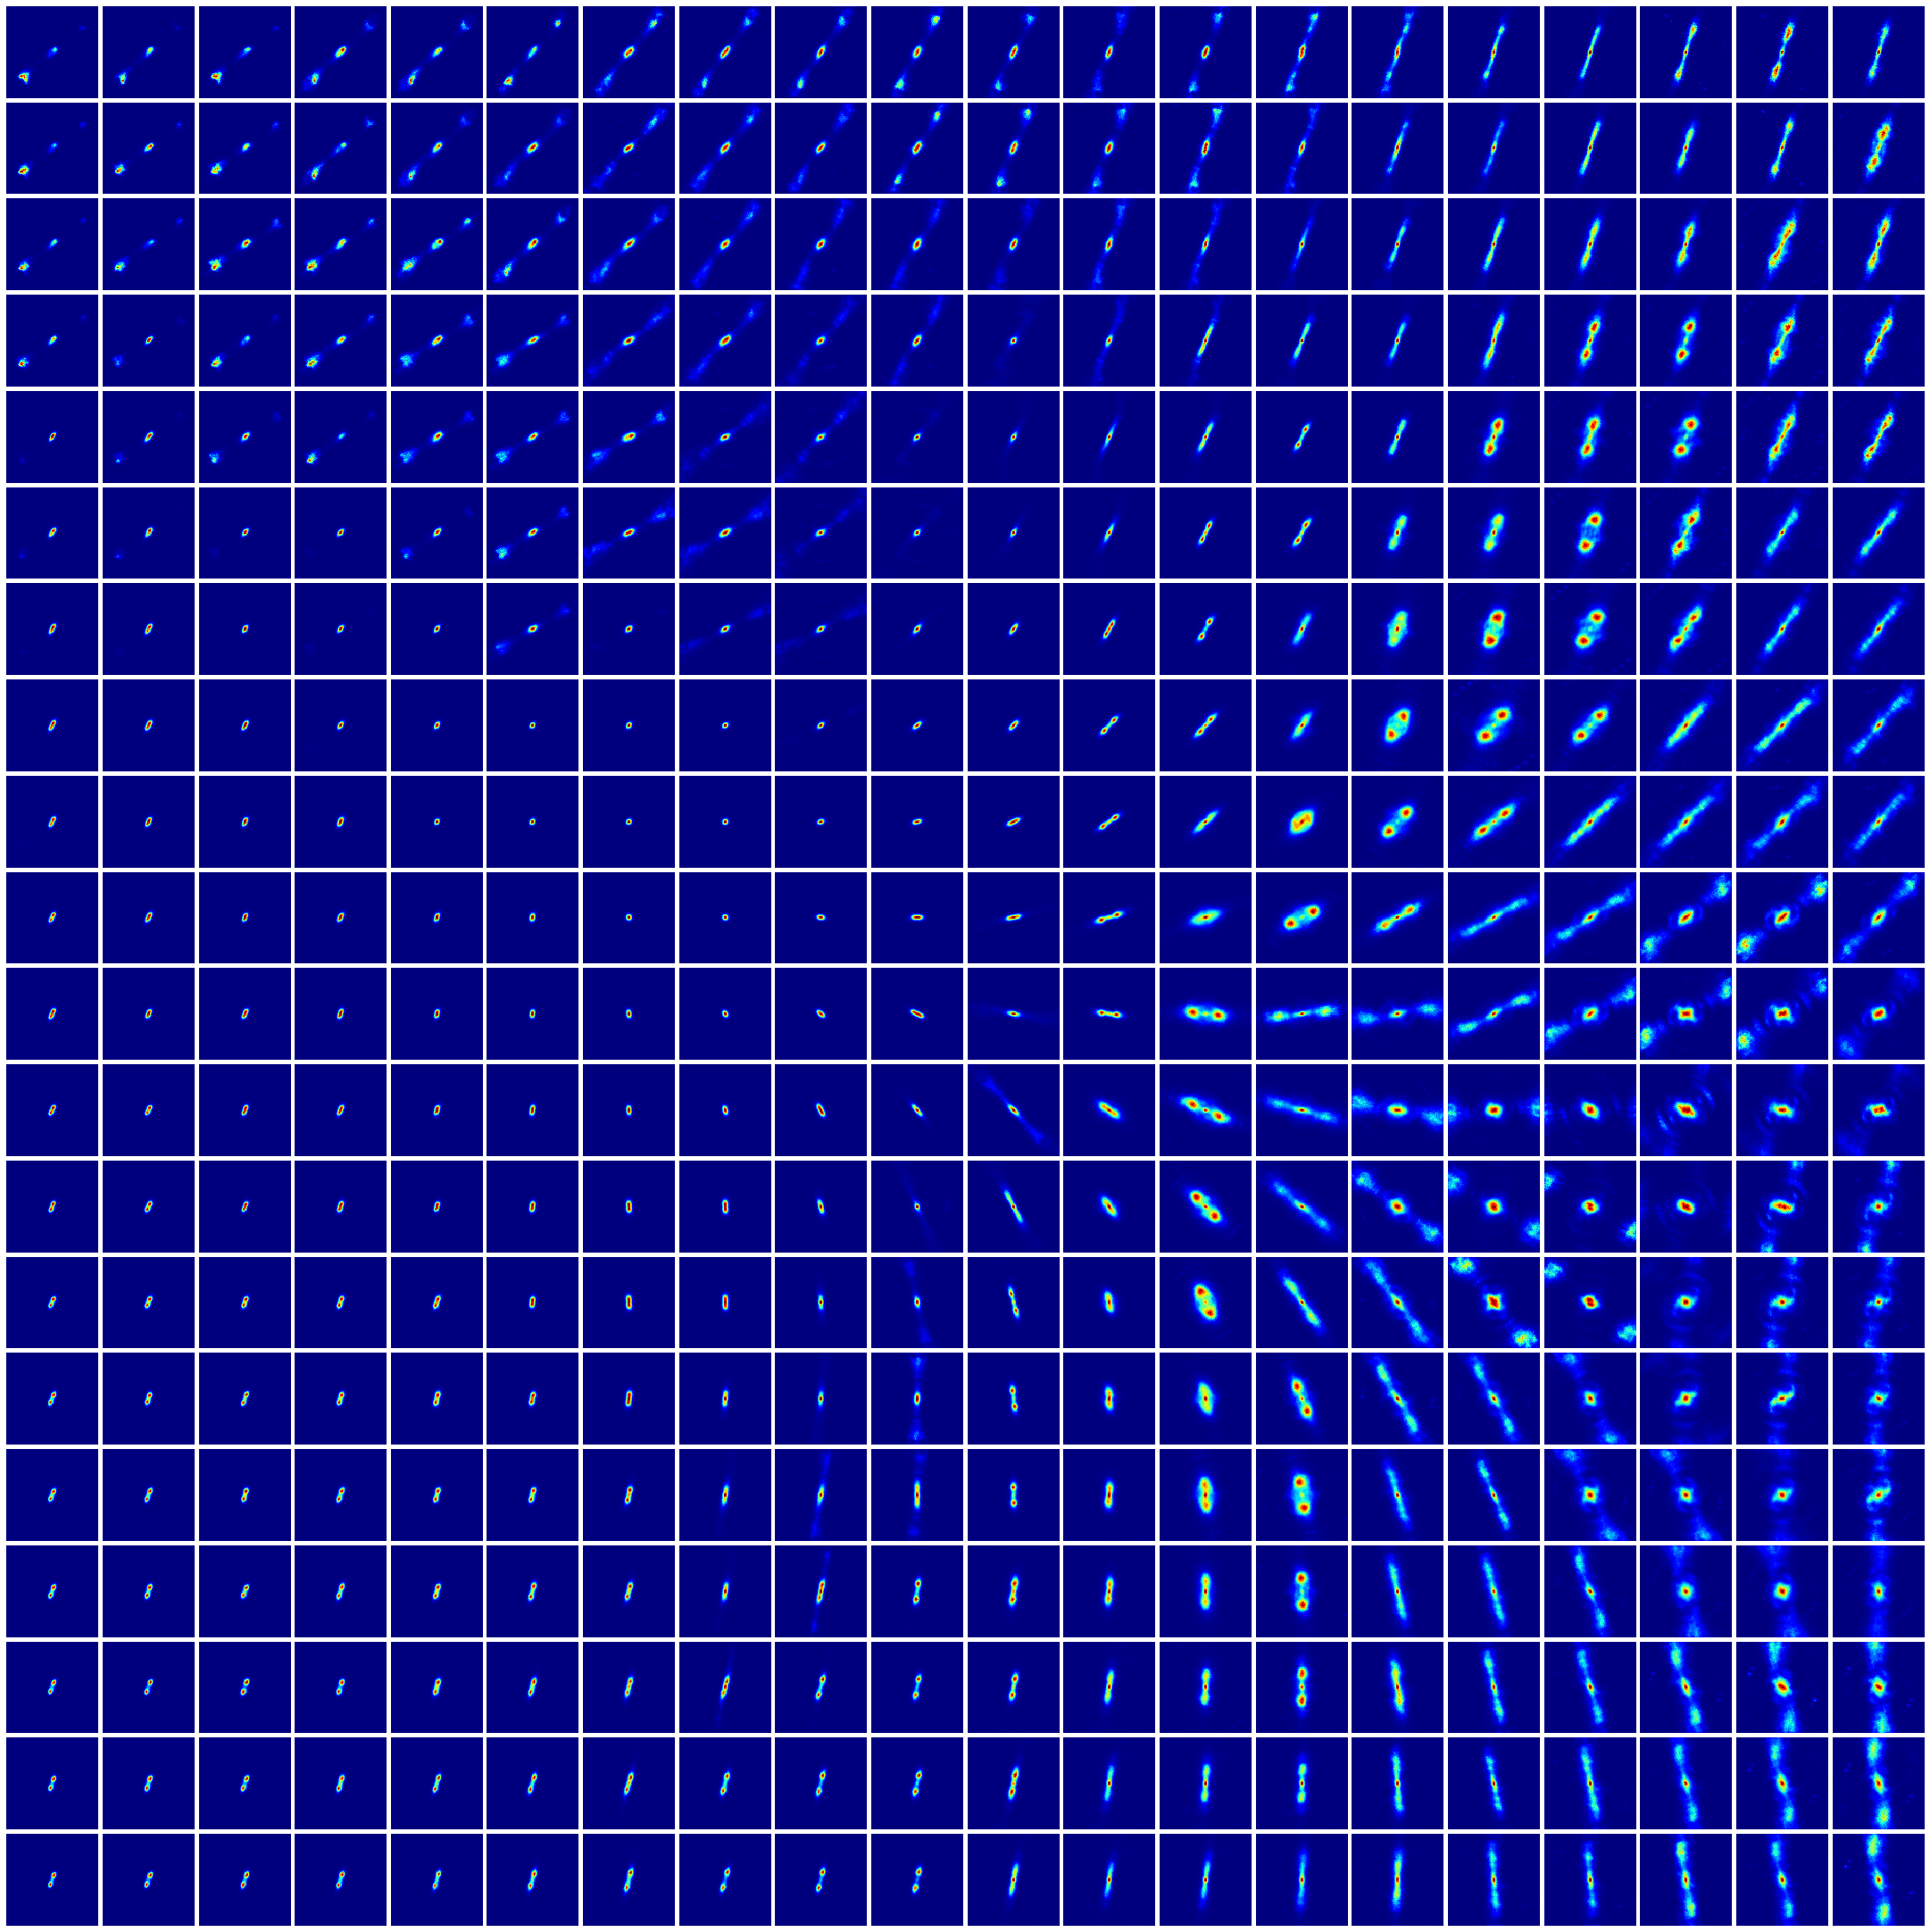

In [506]:
load_checkpoint(3200)

z = torch.randn(2).cuda()
count_x=-4.0
count_y_2=-4.0
count_y=count_y_2
x=0
y=0
plt.figure(0)
plt.figure(figsize=(30,30))
for i in range (0,20):
    for j in range (0,20):
        z[0]=count_x
        z[1]=count_y
        
        x_torch=vae.decoder(z)
        img_rec=x_torch.reshape(100,100).cpu().detach().numpy()
        ax = plt.subplot2grid((20,20), (i,j))
        ax.imshow(img_rec,cmap='jet')
        ax.set_axis_off()
        x=x+1
        count_y=count_y+0.4
    y=y+1
    count_x=count_x+0.4
    count_y=count_y_2
    
    
#sample = vae.decoder(z)
plt.tight_layout(pad = 0.5)
plt.show()

# Sample generation and 

## Experimentatiom for Inception

In [18]:
transform = transforms.Compose([
     #    transforms.CenterCrop(28),
    transforms.RandomRotation(0.,360.),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])
trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=500)

Files already downloaded and verified


In [114]:
x,y = trainloader

In [180]:
for i in range(0,80,5):
    print(i)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75


In [182]:
#def cropping_score(edge_size,x):

inception_score = []
edge_value = []
for i in range(0,80,5):
    fullsize_image = np.zeros((500,1,150,150))
    edge = i
    for i in range (0,500):
        x_tocrp = x[0][i,0,:,:].cpu().detach().numpy()
        fullsize_image[i,0,edge:150-edge,edge:150-edge]=x_tocrp[edge:150-edge,edge:150-edge]
    image_to_test = torch.from_numpy(fullsize_image).float().to("cuda:0")

    valid_pred = classification_model(image_to_test)
    m = nn.Softmax(dim=1)
    values=m(valid_pred).cpu().detach().numpy()
    score = calculate_inception_score(values)
    inception_score.append(score)
    edge_value.append(edge_value)


In [ ]:
plt.plot(inception_score,edge_value)

In [ ]:
plt.imshow(fullsize_image[499][0])

In [127]:
image_to_test.shape

torch.Size([500, 1, 150, 150])

In [85]:
print(inception_scoring())

1.0046775


In [ ]:
# Plot Reduced Dimension of Real Data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))

for x in trainloader:
    x = x[0].cuda()
    
array_train= next(iter(trainloader))[0].numpy()

array_train=(array_train-np.min(array_train))/(np.max(array_train)-np.min(array_train))

array_train_cuda = torch.from_numpy(array_train).float().to("cuda:0")
array_ttrain_labels= next(iter(trainloader))[1].numpy()

In [ ]:
reduced_dimension_array = np.zeros((550,10))

for ii in range (0,550):
    reduced_dimension_array[ii,:]=vae.encoder(array_train_cuda[ii][0][25:125,25:125])[0].cpu().detach().numpy()

    



In [ ]:
plt.figure(0)
plt.figure(figsize=(30,30))
plots = []

labels = {
    0: '0',
    1: '1' ,
    2: '2' ,
    3: '3' ,
    4: '4' ,
    5: '5' ,
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}
for i in range(0,10):
    for j in range(0,10):
        if (j <= i) and (i != j):
            ax = plt.subplot2grid((10,10), (i,j))
            ax.scatter(reduced_dimension_array[:,j][array_ttrain_labels==1],reduced_dimension_array[:,i][array_ttrain_labels==1])
            ax.scatter(reduced_dimension_array[:,j][array_ttrain_labels==0],reduced_dimension_array[:,i][array_ttrain_labels==0])
                
                
        if j == i:
            ax = plt.subplot2grid((10,10), (i,j))
            ax.hist(reduced_dimension_array[:,j][array_ttrain_labels==1], bins = 50)
            ax.hist(reduced_dimension_array[:,j][array_ttrain_labels==0], bins = 50)
            
            
        if j == 0:
            plt.ylabel(labels.get(i),fontsize=9)
                
        if i == 9:
            plt.xlabel(labels.get(j),fontsize=9)
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(reduced_dimension_array[:,0][array_ttrain_labels==1],reduced_dimension_array[:,9][array_ttrain_labels==1],label='FRI')
plt.scatter(reduced_dimension_array[:,0][array_ttrain_labels==0],reduced_dimension_array[:,9][array_ttrain_labels==0],label='FRII')
plt.legend()

In [ ]:
save_checkpoint()

In [ ]:
i=400
reconstructed_image=vae.decoder(vae.encoder(array_train_cuda[i][0][25:125,25:125])[0]).reshape((100,100)).cpu().detach().numpy()
input_image=array_train_cuda[i][0][25:125,25:125].cpu().detach().numpy()
input_image-reconstructed_image

In [ ]:
plt.imshow(reconstructed_image)
plt.colorbar()

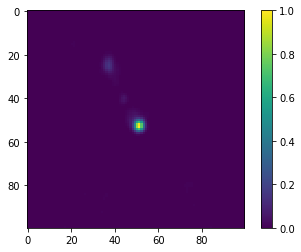

In [117]:
plt.imshow(input_image)
plt.colorbar()

In [23]:
train_loader,test_loader = dataloader_first_FRDEEP()

Files already downloaded and verified
Files already downloaded and verified


In [25]:
for x1, y1 in train_loader:
        x1 = x1.cpu().detach().numpy()
        x1[x1==0]=100
        print(np.min(x1))
        

0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684
0.0039215684